In [1]:
!pip install autogluon-multimodal -qq

In [2]:
import pandas as pd
import catboost as ctb
import numpy as np
import autogluon.multimodal as agmm
import seaborn as sns
import matplotlib.pyplot as plt

2025-10-03 11:42:46.850091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759491766.872107    3327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759491766.878810    3327 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_parquet('/kaggle/input/vseros-avito-stage1/train_dataset.parquet')
test = pd.read_parquet('/kaggle/input/vseros-avito-stage1/test_dataset.parquet')
sub = pd.read_csv('/kaggle/input/vseros-avito-stage1/sample_submission.csv')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


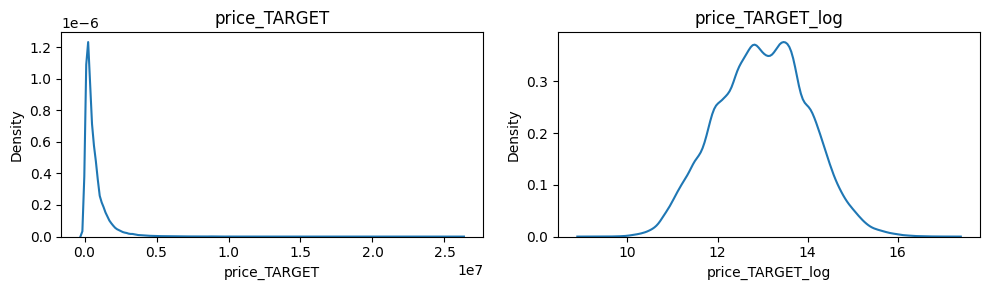

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(train['price_TARGET'], ax=axes[0])
axes[0].set_title('price_TARGET')
sns.kdeplot(np.log1p(train['price_TARGET']), ax=axes[1])
axes[1].set_title('price_TARGET_log')
axes[1].set_xlabel('price_TARGET_log')
plt.tight_layout()
plt.show()

In [5]:
cat_cols = ['body_type', 'drive_type', 'engine_type', 'pts', 'diski', 'steering_wheel', 'usilitel_rul', 'electropodemniki', 'fary', 'salon', 'upravlenie_klimatom']
text_cols = ["aktivnaya_bezopasnost_mult", "audiosistema_mult", "shini_i_diski_mult", "electroprivod_mult", "fary_mult", "multimedia_navigacia_mult", "obogrev_mult", "pamyat_nastroek_mult", "podushki_bezopasnosti_mult", "pomosh_pri_vozhdenii_mult", "protivoygonnaya_sistema_mult", "salon_mult", "upravlenie_klimatom_mult", 'equipment', 'color']

In [6]:
multiple_features = [
    'aktivnaya_bezopasnost_mult', 'audiosistema_mult', 'shini_i_diski_mult',
    'electroprivod_mult', 'fary_mult', 'multimedia_navigacia_mult',
    'obogrev_mult', 'pamyat_nastroek_mult', 'podushki_bezopasnosti_mult',
    'pomosh_pri_vozhdenii_mult', 'protivoygonnaya_sistema_mult', 'salon_mult',
    'upravlenie_klimatom_mult'
]

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
def clean_array_data(arr):
    """Очищает numpy массив от None значений"""
    result = []
    for item in arr:
        if item is None:
            result.append([])
        elif hasattr(item, '__iter__') and not isinstance(item, str):
            result.append([x for x in item if x is not None])
        else:
            result.append([item] if item is not None else [])
    return result

new_features = []
test_features = []

for col in multiple_features:

    clean_data = clean_array_data(train[col])
    
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(clean_data)
    
    new_features.append(pd.DataFrame(encoded, columns = col + "_" + mlb.classes_))
    test_features.append(pd.DataFrame(mlb.transform(clean_array_data(test[col])), columns = col + "_" + mlb.classes_))

In [9]:
train = pd.concat([train, pd.concat(new_features, axis=1)], axis=1)
test = pd.concat([test, pd.concat(test_features, axis=1)], axis=1)

In [10]:
# train[text_cols] = train[text_cols].astype(str)
# test[text_cols] = test[text_cols].astype(str)

In [11]:
def combine_text_features(row):
    text_parts = []
    for col in text_cols:
        if pd.notna(row[col]) and row[col] != "":
            if row[col] != '[None]':
                text_parts.append(f"{col} : {row[col]}")
    if len(text_parts) == 0:
        return "None"
    return "\n".join(text_parts)

def prepare_dataset(df):
    df = df.copy()
    df[[f'image_{i}' for i in range(4)]] = [[f"{idx}_{i}" for i in range(4)] for idx in df['ID']]
    df['audiosistema'] = df['audiosistema'].fillna('0').str[0].astype(int)
    df['owners_count'] = df['owners_count'].replace({'> 3': 4}).astype(int)
    df['crashes_count'] = df['crashes_count'].replace({'3+': 4}).fillna('-1').astype(int)
    # df['text'] = df.apply(combine_text_features, axis=1)
    return df

train_df = prepare_dataset(train)
test_df = prepare_dataset(test)

In [12]:
# features = ['body_type', 'drive_type', 'engine_type', 'doors_number', 'pts',
#        'audiosistema', 'diski', 'electropodemniki', 'fary', 'salon',
#        'upravlenie_klimatom', 'usilitel_rul', 'steering_wheel',
#        'crashes_count', 'owners_count', 'mileage', 'latitude', 'longitude',
#        # , 'image_0', 'image_1', 
#             # 'image_2', 'image_3',
#             'text']
features = train_df.drop(columns=multiple_features + ['ID', 'price_TARGET', 'image_1', 'image_2', 'image_3']).columns.values
target = 'price_TARGET'

In [13]:
train_df[cat_cols + ['equipment', 'color']] = train_df[cat_cols + ['equipment', 'color']].fillna('None')
test_df[cat_cols + ['equipment', 'color']] = test_df[cat_cols + ['equipment', 'color']].fillna('None')

In [14]:
class MdAPEMetric:
    def is_max_optimal(self):
        return False  # Минимизируем ошибку (меньше = лучше)
    
    def evaluate(self, approxes, target, weight):
        """
        approxes - список предсказаний
        target - настоящие значения  
        weight - веса (необязательно)
        """
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        
        y_pred = np.array(approxes[0])
        y_true = np.array(target)
        
        # Обработка нулевых и очень маленьких значений
        epsilon = 1e-10
        mask = np.abs(y_true) > epsilon
        
        if np.sum(mask) == 0:
            return 1.0, 1  # Если все значения нулевые, возвращаем максимальную ошибку
        
        y_true_filtered = y_true[mask]
        y_pred_filtered = y_pred[mask]
        
        # Вычисляем абсолютные процентные ошибки (без умножения на 100)
        ape = np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)
        mdape_value = np.median(ape)  # Диапазон [0, ∞), но обычно [0, 1]
        
        return mdape_value, 1
    
    def get_final_error(self, error, weight):
        return error

In [15]:
# tr_embs = np.load('/kaggle/input/vseros-avito-effnet-b3-embeddings/train_embeddings_b3.npy')
# test_embs = np.load('/kaggle/input/vseros-avito-effnet-b3-embeddings/test_embeddings_b3.npy')

In [16]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=256)
# train_df[[f'embs_{i}' for i in range(pca.n_components)]] = pca.fit_transform(tr_embs)
# test_df[[f'embs_{i}' for i in range(pca.n_components)]] = pca.transform(test_embs)
# features = np.hstack([features, [f'embs_{i}' for i in range(pca.n_components)] + ['target']])

In [17]:
features = np.hstack([features, ['target', ]])

In [18]:
train_df['target'] = np.log1p(train_df[target] // 1000)

In [19]:
def median_ape(y_true, y_pred, epsilon=1e-10):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Проверка размеров
    if len(y_true) != len(y_pred):
        raise ValueError("y_true и y_pred должны иметь одинаковую длину")
    
    # Избегаем деления на ноль
    denominator = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    
    # Вычисляем абсолютные процентные ошибки
    ape = np.abs((y_true - y_pred) / denominator)
    
    # Возвращаем медиану
    return float(np.median(ape))

In [20]:
from autogluon.core.metrics import make_scorer

mdape = make_scorer(name='mdape',
                    score_func=median_ape,
                    optimum=0,
                    greater_is_better=False,
                    needs_pred=True,
                   )

In [21]:
# predictor = agt.TabularPredictor(label='target', eval_metric=mdape).fit(train_df[features], time_limit=3600, hyperparameters={
# 	'NN_TORCH': [{}],
# 	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, {'learning_rate': 0.03, 'num_leaves': 128, 'feature_fraction': 0.9, 'min_data_in_leaf': 3, 'ag_args': {'name_suffix': 'Large', 'priority': 0, 'hyperparameter_tune_kwargs': None}}],
# 	# 'CAT': [{}],
# 	'XGB': [{}],
# 	'FASTAI': [{}],
# 	# 'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
# 	# 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
# }, presets='best')

In [22]:
img_cols = ['image_0', 'image_1', 'image_2', 'image_3']
train_df[img_cols] = '/kaggle/input/vseros-avito-stage1/AvitoAuto/АвтоПрайс/train_images/' + train_df[img_cols] + '.jpg'
test_df[img_cols] = '/kaggle/input/vseros-avito-stage1/AvitoAuto/АвтоПрайс/test_images/' + test_df[img_cols] + '.jpg'

In [23]:
from sklearn.model_selection import train_test_split

tr, _ = train_test_split(train_df, train_size=0.35, stratify=pd.qcut(np.log1p(train_df['price_TARGET']), 400, labels=range(400)), random_state=0)

In [24]:
model_hp = {
    # 'model.hf_text.checkpoint_name': 'microsoft/deberta-v3-base',
            'model.timm_image.checkpoint_name': 'convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384',
           "optim.patience": 6,
            "optim.max_epochs": 5,
           "optim.top_k": 1,
            "env.per_gpu_batch_size": 2}
predictor = agmm.MultiModalPredictor(label='target', eval_metric=mdape, hyperparameters=model_hp)
predictor.fit(tr[['image_0', 'image_1', 'image_2', 'image_3', 'target']], column_types={'image_0': 'image_path',
                                                                                         'image_1': 'image_path',
                                                                                         'image_2': 'image_path',
                                                                                         'image_3': 'image_path'}, time_limit=4 * 3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20251003_114256"
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          46
Pytorch Version:    2.6.0+cu124
CUDA Version:       12.4
GPU Count:          4
Memory Avail:       184.07 GB / 188.70 GB (97.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (9.868689046993433, 2.772588722239781, 6.09522, 1.00197)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨

model.safetensors:   0%|          | 0.00/801M [00:00<?, ?B/s]

GPU Count: 4
GPU Count to be Used: 4

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
INFO: 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:434: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [1536, 1, 7, 7], strides() = [49, 1, 7, 1]
bucket_view.sizes() = [1536, 1, 7, 7], strides() = [49, 49, 7, 1] (Triggered internally at /pytorch/torch/csrc/distributed/c10d/reducer.cpp:327.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [1536, 1, 7, 7], strides() 

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 86: 'val_rmse' reached 0.40963 (best 0.40963), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=0-step=86.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 172: 'val_rmse' reached 0.36827 (best 0.36827), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=0-step=172.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 259: 'val_rmse' reached 0.36215 (best 0.36215), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=1-step=259.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 345: 'val_rmse' reached 0.32920 (best 0.32920), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=1-step=345.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 432: 'val_rmse' reached 0.32767 (best 0.32767), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=2-step=432.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 518: 'val_rmse' reached 0.31361 (best 0.31361), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=2-step=518.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 605: 'val_rmse' reached 0.30525 (best 0.30525), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=3-step=605.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 691: 'val_rmse' reached 0.29409 (best 0.29409), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=3-step=691.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 778: 'val_rmse' reached 0.29216 (best 0.29216), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=4-step=778.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 864: 'val_rmse' reached 0.29118 (best 0.29118), saving model to '/kaggle/working/AutogluonModels/ag-20251003_114256/epoch=4-step=864.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/kaggle/working/AutogluonModels/ag-20251003_114256")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [26]:
embs_tr = predictor.extract_embedding(train_df)
embs_tst = predictor.extract_embedding(test_df)

/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/data/infer_types.py:248: UserWarning: Among 500 sampled images in column 'image_1', 2% images can't be open. You may need to thoroughly check your data to see the percentage of missing images, and estimate the potential influence. By default, we use an image with zero pixels. You can also set hyperparameter 'data.image.missing_value_strategy' to be 'skip', which skips samples that contain a missing image.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/data/infer_types.py:248: UserWarning: Among 500 sampled images in column 'image_2', 3% images can't be open. You may need to thoroughly check your data to see the percentage of missing images, and estimate the potential influence. By default, we use an image with zero pixels. You can also set hyperparameter 'data.image.missing_value_strategy' to be 'skip', which skips samples that contain a missing image.
  warnings.warn(
/usr/local/lib/python3.11/

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/data/infer_types.py:248: UserWarning: Among 500 sampled images in column 'image_1', 2% images can't be open. You may need to thoroughly check your data to see the percentage of missing images, and estimate the potential influence. By default, we use an image with zero pixels. You can also set hyperparameter 'data.image.missing_value_strategy' to be 'skip', which skips samples that contain a missing image.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/data/infer_types.py:248: UserWarning: Among 500 sampled images in column 'image_2', 3% images can't be open. You may need to thoroughly check your data to see the percentage of missing images, and estimate the potential influence. By default, we use an image with zero pixels. You can also set hyperparameter 'data.image.missing_value_strategy' to be 'skip', which skips samples that contain a missing image.
  warnings.warn(
/usr/local/lib/python3.11/

Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
embs_tr.shape

(70000, 1536)

In [28]:
np.save('tr_embeddings_convnext-large.npy', embs_tr)
np.save('test_embeddings_convnext-large.npy', embs_tst)

In [29]:
sub['target'] = np.expm1(predictor.predict(test_df, as_pandas=False)) * 1000
sub.to_csv('avito_gluon_convnext-large_only-35per.csv', index=False)

/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/data/infer_types.py:248: UserWarning: Among 500 sampled images in column 'image_1', 2% images can't be open. You may need to thoroughly check your data to see the percentage of missing images, and estimate the potential influence. By default, we use an image with zero pixels. You can also set hyperparameter 'data.image.missing_value_strategy' to be 'skip', which skips samples that contain a missing image.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/data/infer_types.py:248: UserWarning: Among 500 sampled images in column 'image_2', 3% images can't be open. You may need to thoroughly check your data to see the percentage of missing images, and estimate the potential influence. By default, we use an image with zero pixels. You can also set hyperparameter 'data.image.missing_value_strategy' to be 'skip', which skips samples that contain a missing image.
  warnings.warn(
/usr/local/lib/python3.11/

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# from sklearn.model_selection import KFold
# import warnings
# warnings.filterwarnings('ignore')

# cv = KFold(n_splits=5)
# models = []
# scores = []
# for tr_idx, val_idx in cv.split(train_df):
#     tr, val = train_df.iloc[tr_idx], train_df.iloc[val_idx]
#     model = ctb.CatBoostRegressor(
#         eval_metric=MdAPEMetric(), 
#         random_seed=42,
#         verbose=25,
#         cat_features=cat_cols + ['equipment', 'color'],
#         # text_features=['text']
#     )
    
#     model.fit(
#         tr[features], tr[target] // 1000,
#         eval_set=(val[features], val[target] // 1000),
#         early_stopping_rounds=50,
#     )
#     scores.append(model.get_best_score()['validation']['MdAPEMetric'])
#     models.append(model)

# print(f"CV Score: {np.mean(scores):.5f} ± {np.std(scores):.5f}")

In [ ]:
# pd.DataFrame({"feature": models[0].feature_names_, "score": np.mean([models[i].feature_importances_ for i in range(cv.n_splits)], 0)}).sort_values('score', ascending=False).head(20)

In [ ]:
# preds = []
# for i in range(cv.n_splits):
#     preds.append(models[i].predict(test_df[features]))
# # sub['target'] = model.predict(test_df[features])
# sub['target'] = np.mean(preds, 0) * 1000
# sub.to_csv('avito_ctb_baseline_cv5_module1000_multiple_cols_effnetb3_256.csv', index=False)